In [1]:
!pip install python_speech_features
!pip install scipy

  Preparing metadata (setup.py) ... - done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=a7d59bcfd8e102f0b9d8b54b25f8eb4633f3575d27da1dacc9ab82422167663b
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python_speech_features


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from tempfile import TemporaryFile
import os
import math
import pickle
import random
import operator
import librosa
import librosa.display
import soundfile as sf
import random
import IPython.display as ipd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, minmax_scale
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, cohen_kappa_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
def get_random_song():
    path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
    genres = os.listdir(path)
    
    selected_genre = random.choice(genres)
    
    songs = genres = os.listdir(path + "/" + selected_genre)
    
    selected_song = random.choice(songs)
    
    x, sr = librosa.load(path + "/" + selected_genre + "/" + selected_song)
    
#     x, sr = sf.read(path + "/" + selected_genre + "/" + selected_song, always_2d=True)
    
    return (x, sr, selected_genre, path + "/" + selected_genre + "/" + selected_song)
    
    

In [4]:
x, sr, genre, path = get_random_song()
print(genre)
print(path)
ipd.Audio(path)

classical
/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00083.wav


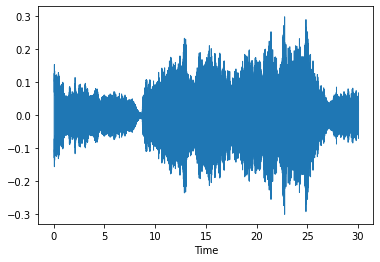

In [5]:
# x, sr = librosa.load(path)
librosa.display.waveshow(x, sr=sr)
plt.show()

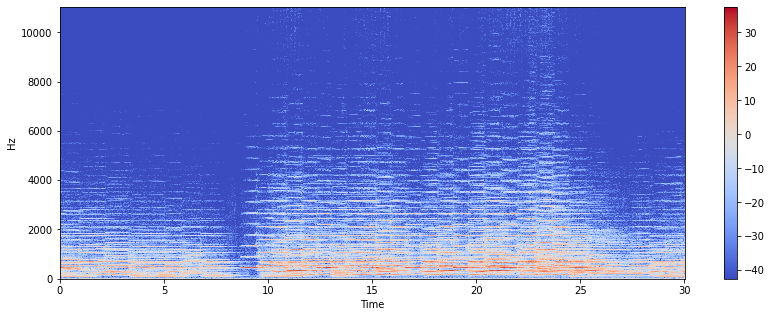

In [6]:
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
plt.colorbar()


**Feature Extraction**

Zero Crossing Rate

In [7]:
zero_crossings = librosa.zero_crossings(x, pad=False)
print(sum(zero_crossings))


33649


In [8]:
mfcc_feat = mfcc(x, sr, winlen = 0.020, appendEnergy=False)

In [9]:
mfcc_feat.mean(0)

array([-51.13788313,  22.28069035, -20.45464228, -13.5545315 ,
       -13.50579009, -16.12014175, -16.59057654, -15.62092694,
        -9.82193564,  -9.21708325,  -4.66419073,  -1.48717934,
         3.76825441])

In [10]:
np.insert(mfcc_feat.mean(0), 0, 79953)

array([ 7.99530000e+04, -5.11378831e+01,  2.22806904e+01, -2.04546423e+01,
       -1.35545315e+01, -1.35057901e+01, -1.61201418e+01, -1.65905765e+01,
       -1.56209269e+01, -9.82193564e+00, -9.21708325e+00, -4.66419073e+00,
       -1.48717934e+00,  3.76825441e+00])

**Feature Extraction**

spectral centroid

In [11]:
spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)
spectral_centroids.shape

(1, 1293)

In [12]:
spectral_centroids[0]

array([939.92619164, 784.69142281, 720.63534109, ..., 716.77613937,
       689.72399583, 700.62976902])

In [13]:
frames = range(len(spectral_centroids[0]))
t = librosa.frames_to_time(frames)

In [14]:
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

In [15]:
len(spectral_centroids[0])

1293

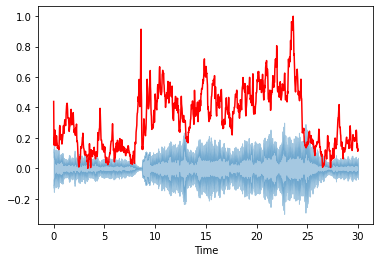

In [16]:
#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids[0]), color='r')

In [17]:
len(mfcc_feat.flatten('F'))

38922

In [18]:
model_tracker = pd.DataFrame(columns=['model','accuracy'])

In [19]:
def update_tracker(name, predictions, y_test):
    accuracy = accuracy_score(predictions, y_test)
    
    model_tracker.loc[model_tracker.shape[0]] = [name, accuracy]
    
    return model_tracker

In [20]:
def parse_audio(x):
    return x.flatten('F')[:x.shape[0]]

In [21]:
data_directory = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'

data = []
labels = []
bad_files = []

for folder in os.listdir(data_directory):
    print(folder)
    for song in os.listdir(data_directory + "/" + folder):
        try:
#             x, sr = librosa.load(data_directory + "/" + folder + "/" + song)
            x, sr = sf.read(data_directory + "/" + folder + "/" + song, always_2d=True)
            #x = parse_audio(x)
            mfcc_feat = mfcc(x, sr, winlen = 0.020, appendEnergy=False)
            means = mfcc_feat.mean(0)
#             zero_crossings = sum(librosa.zero_crossings(x, pad=False))
#             features = np.insert(means, 0, zero_crossings)
#             spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)
#             features = np.insert(features, 0, spectral_centroids[0].mean())
            data.append(means)
            labels.append(folder)
        except Exception:
            bad_files.append(song)
        

disco
metal
reggae
blues
rock
classical
jazz
hiphop
country
pop


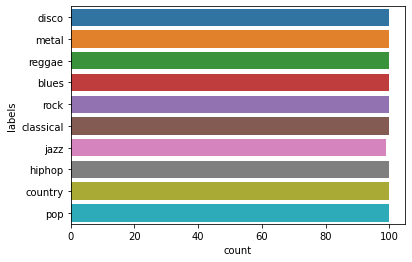

In [22]:
label_df = pd.DataFrame(labels, columns=['labels'])
ax = sns.countplot(y="labels", data=label_df)

There is no class imbalance in this dataset.

In [23]:
X = np.array(data)
Y = labels

In [24]:
le = LabelEncoder()
Y_encoded = le.fit_transform(Y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded)

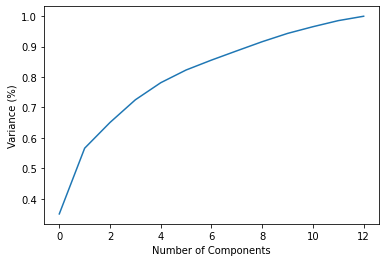

In [26]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA().fit(X_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()

In [27]:
model = XGBClassifier()
model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [28]:
y_predict = model.predict(X_test_scaled)
update_tracker('xgb', y_predict, y_test)

,model,accuracy
0,xgb,0.58


In [29]:
grid_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

model = GridSearchCV(KNeighborsClassifier(), grid_params, cv=5, n_jobs=-1)
model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']})

In [30]:
y_predict = model.predict(X_test_scaled)
update_tracker('knn', y_predict, y_test)

,model,accuracy
0,xgb,0.580
1,knn,0.548


In [31]:
X_train_reshaped = X_train_scaled.reshape(-1, 1, 13)
X_test_reshaped = X_test_scaled.reshape(-1, 1, 13)

In [32]:
input_shape=X_train_reshaped[0].shape

model = Sequential()
model.add(LSTM(128,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['acc'])

history = model.fit(X_train_reshaped, y_train, epochs=50,batch_size=76,
                    validation_data=(X_test_reshaped, y_test), shuffle=False)


2022-06-01 19:31:41.720197: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-06-01 19:31:42.430095: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
10/10 [==============================] - 3s 75ms/step - loss: 2.2895 - acc: 0.1175 - val_loss: 2.2643 - val_acc: 0.2320
Epoch 2/50
10/10 [==============================] - 0s 16ms/step - loss: 2.2318 - acc: 0.2056 - val_loss: 2.2068 - val_acc: 0.2840
Epoch 3/50
10/10 [==============================] - 0s 14ms/step - loss: 2.1665 - acc: 0.2577 - val_loss: 2.1325 - val_acc: 0.3200
Epoch 4/50
10/10 [==============================] - 0s 21ms/step - loss: 2.0762 - acc: 0.2951 - val_loss: 2.0551 - val_acc: 0.3200
Epoch 5/50
10/10 [==============================] - 0s 14ms/step - loss: 2.0147 - acc: 0.3204 - val_loss: 1.9873 - val_acc: 0.3240
Epoch 6/50
10/10 [==============================] - 0s 18ms/step - loss: 1.9321 - acc: 0.3471 - val_loss: 1.9233 - val_acc: 0.3360
Epoch 7/50
10/10 [==============================] - 0s 9ms/step - loss: 1.8558 - acc: 0.3418 - val_loss: 1.8576 - val_acc: 0.3360
Epoch 8/50
10/10 [==============================] - 0s 8ms/step - loss: 1.7878 - acc

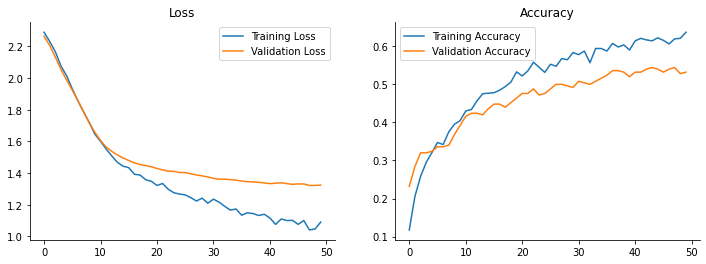

In [33]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history["loss"])), y = history.history["loss"], ax = axes[0], label = "Training Loss")
sns.lineplot(x = range(len(history.history["loss"])), y = history.history["val_loss"], ax = axes[0], label = "Validation Loss")

sns.lineplot(x = range(len(history.history["acc"])), y = history.history["acc"], ax = axes[1], label = "Training Accuracy")
sns.lineplot(x = range(len(history.history["acc"])), y = history.history["val_acc"], ax = axes[1], label = "Validation Accuracy")
axes[0].set_title("Loss"); axes[1].set_title("Accuracy")

sns.despine()
plt.show()

In [34]:
def decode_prediction(lstm_prediction):
    max_val = max(lstm_prediction)
    result = np.where(lstm_prediction == max_val)
    
    return result[0][0]

In [35]:
y_predict = model.predict(X_test_reshaped)
lstm_results = np.array([decode_prediction(x) for x in y_predict])

update_tracker('lstm', lstm_results, y_test)

,model,accuracy
0,xgb,0.580
1,knn,0.548
2,lstm,0.532


**Logistic Regression**

In [36]:
lm = LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train_scaled, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [37]:
y_predict = lm.predict(X_test_scaled)

In [38]:
accuracy_score(y_predict, y_test)

0.516

In [39]:
update_tracker('log', y_predict, y_test)

,model,accuracy
0,xgb,0.580
1,knn,0.548
2,lstm,0.532
3,log,0.516
